In [1]:
import numpy as np 
import os 
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import colors 
from matplotlib.ticker import PercentFormatter 

def triangular_plot(chains):
    data=chains
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(20,20))
    for i in range(ndim):
        ax = fig.add_subplot(ndim,ndim,i*ndim+i+1)
        ax.hist(data[:,i], 100, color="k", histtype="step")
        ax.set_title(f"x{i}")
    for i in range(ndim):
        for j in range(i):
            plt.subplot(ndim,ndim,ndim*i+j+1)
            counts,xbins,ybins,image = plt.hist2d(data[:,j],data[:,i],bins=100
                                      ,norm=LogNorm()
                                      , cmap = plt.cm.rainbow)
            plt.colorbar()
            plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
            linewidths=0.5, cmap = plt.cm.rainbow, levels = [1,100,1000,10000])
    plt.show()

def triangular_plot_slopes(chains):
    data=chains.numpy()
    nsteps,ndim=chains.shape
    fig = plt.figure(figsize=(15,15))
    for i in range(ndim):
        for j in range(i):
            ax=fig.add_subplot(ndim,ndim,ndim*i+j+1)
            those_slope0=np.extract(np.abs(data[:,0])>0.2,data[:,i]/data[:,j])
            those_slope=np.extract(np.abs(those_slope0)<10,those_slope0)
            ax.hist(those_slope,bins=100)
            ax.set_title(f"x{j}/x{i}")
            #ax.set_ylabel(f"x{i}")
    plt.show()

In [2]:
import tensorflow as tf
import numpy as np

# number of points
n_points = 100000

def V1(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return x2**2 - 2*x2*x3 + x3**2 + 2*x2*x4 - 2*x3*x4 + 2*x4**2

def V2(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return (x4**2+(x2-x3+x4)**2+(x1+x2+x3+x4)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1-(-1+np.sqrt(3))*(x2+x3+x4))**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+(1+np.sqrt(3))*(x2+x3+x4))**2)

def V3(x):
    x1,x2,x3,x4=tf.split(x, 4, axis=1)
    return (x4**2+(x2-x3+x4)**2+(x1+x2+x3+x4)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+x2+x3+x4-np.sqrt(3)*(x2+x3+x4)**2)**2)*(x4**2+(x2-x3+x4)**2+1/4*(x1+x2+x3+x4+np.sqrt(3)*(x2+x3+x4)**2)**2)

# compute (||∇V||^2)
def grad_norm_squared(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    norm_squared = tf.reduce_sum(gradients**2, axis=1)  # ||∇V||^2 at each point
    return norm_squared

def get_grad(V, x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = V(x)  # compute V at each point
    gradients = tape.gradient(loss, x)  # compute ∇V at each point
    return gradients


2024-10-15 10:32:57.711150: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 10:32:57.726902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 10:32:57.731024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 10:32:57.741787: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 10:32:58.585493: W tensorflow/compiler/tf2

In [3]:
# V1 Potential 

In [3]:
# randomly initialize the points
x1 = tf.Variable(np.random.rand(n_points, 4)-2, dtype=tf.float32)

2024-10-15 10:33:06.872574: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-10-15 10:33:06.872625: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:135] retrieving CUDA diagnostic information for host: eloy-HP-ZBook
2024-10-15 10:33:06.872630: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:142] hostname: eloy-HP-ZBook
2024-10-15 10:33:06.872705: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:166] libcuda reported version is: 550.107.2
2024-10-15 10:33:06.872726: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:170] kernel reported version is: 550.107.2
2024-10-15 10:33:06.872730: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:249] kernel version seems to match DSO: 550.107.2


In [4]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)

#optimizer = tf.optimizers.Adam(learning_rate=alpha)
optimizer = tf.optimizers.Adam(learning_rate=init_alpha)

# Learning loop 

alpha = init_alpha
update_alpha = False

for step in range(2400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V1, x1))  # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x1])
      
    if update_alpha and step % 300 == 0 and step != 0:
        alpha = alpha/2
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if (not update_alpha) and step % 200 ==0 :
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10:
        update_alpha = True
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x1]))
    
    if step % 10 == 0:
        print(f"Step {step}: ||∇V||^2 = {loss.numpy(),alpha}")
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Step 0: ||∇V||^2 = (5809892.0, 0.01)
Step 10: ||∇V||^2 = (4272766.0, 0.01)
Step 20: ||∇V||^2 = (3042241.0, 0.01)
Step 30: ||∇V||^2 = (2115061.0, 0.01)
Step 40: ||∇V||^2 = (1453203.5, 0.01)
Step 50: ||∇V||^2 = (1000982.2, 0.01)
Step 60: ||∇V||^2 = (702257.94, 0.01)
Step 70: ||∇V||^2 = (509873.34, 0.01)
Step 80: ||∇V||^2 = (388218.12, 0.01)
Step 90: ||∇V||^2 = (312157.75, 0.01)
Step 100: ||∇V||^2 = (264745.84, 0.01)
Step 110: ||∇V||^2 = (234937.47, 0.01)
Step 120: ||∇V||^2 = (215728.44, 0.01)
Step 130: ||∇V||^2 = (202781.38, 0.01)
Step 140: ||∇V||^2 = (193468.12, 0.01)
Step 150: ||∇V||^2 = (186228.89, 0.01)
Step 160: ||∇V||^2 = (180156.64, 0.01)
Step 170: ||∇V||^2 = (174735.1, 0.01)
Step 180: ||∇V||^2 = (169677.22, 0.01)
Step 190: ||∇V||^2 = (164827.8, 0.01)
Step 200: ||∇V||^2 = (160105.94, 0.01)
Step 210: ||∇V||^2 = (120557.37, 0.01)
Step 220: ||∇V||^2 = (89266.14, 0.01)
Step 230: ||∇V||^2 = (64469.297, 0.01)
Step 240: ||∇V||^2 = (45598.63, 0.01)
Step 250: ||∇V||^2 = (31701.256, 0.01)
S

In [5]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V1,x1)**2,axis=1).numpy()>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 0
Number of points with ||∇V||^2 > 1e-08 : 0
Number of points with ||∇V||^2 > 1e-09 : 0
Number of points with ||∇V||^2 > 1e-10 : 0
Number of points with ||∇V||^2 > 1e-11 : 45643
Number of points with ||∇V||^2 > 1e-12 : 90481
Number of points with ||∇V||^2 > 1e-13 : 99117
Number of points with ||∇V||^2 > 1e-14 : 99637


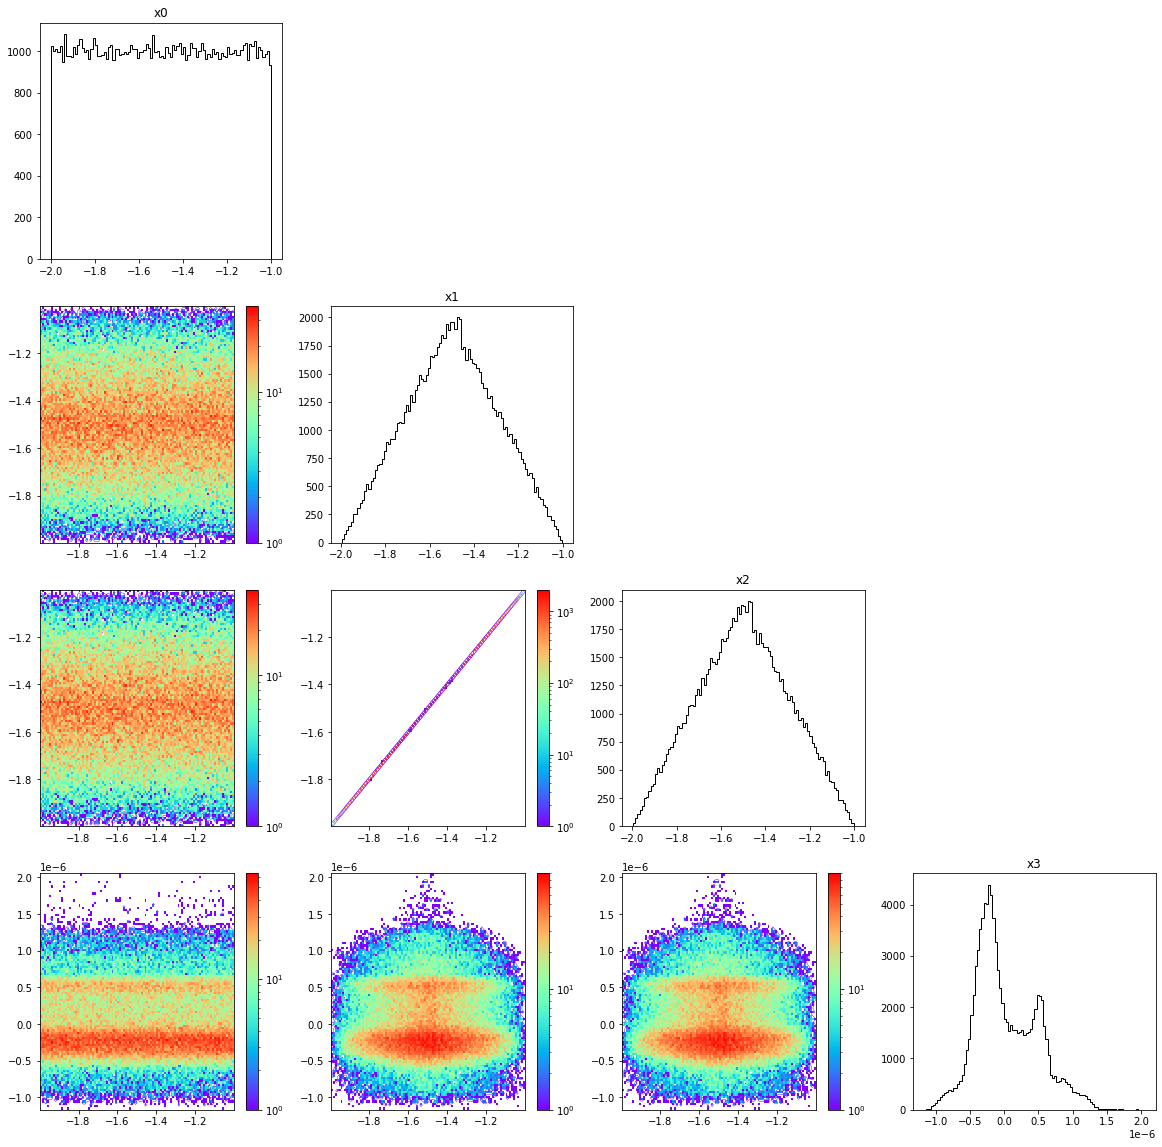

In [6]:
triangular_plot(x1.numpy())

In [10]:
#V2 potential plots and stats

In [11]:
# randomly initialize the points
x2 = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)

In [12]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)

#optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
optimizer = tf.optimizers.SGD(learning_rate=init_alpha)

# Learning loop 

alpha = init_alpha
update_alpha = False
update_opt = True 
for step in range(2400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V2, x2))  # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x2])
      
    if update_alpha and step % 300 == 0 and step != 0:
        alpha = alpha/2
        optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10 and update_opt:
        update_alpha = True
        update_opt = False
        print("Turning update_alpha to True and update_opt to False")
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x2]))
    
    if step % 10 == 0:
        print(f"Step {step}: ||∇V||^2 = {loss.numpy(),alpha}")
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = (21634205000000.0, 0.01)
Step 10: ||∇V||^2 = (11335853000000.0, 0.01)
Step 20: ||∇V||^2 = (6243522400000.0, 0.01)
Step 30: ||∇V||^2 = (3779234400000.0, 0.01)
Step 40: ||∇V||^2 = (2525126700000.0, 0.01)
Step 50: ||∇V||^2 = (1830230300000.0, 0.01)
Step 60: ||∇V||^2 = (1408184000000.0, 0.01)
Step 70: ||∇V||^2 = (1129803700000.0, 0.01)
Step 80: ||∇V||^2 = (933525300000.0, 0.01)
Step 90: ||∇V||^2 = (787955000000.0, 0.01)
Step 100: ||∇V||^2 = (675875500000.0, 0.01)
Step 110: ||∇V||^2 = (587144760000.0, 0.01)
Step 120: ||∇V||^2 = (515388200000.0, 0.01)
Step 130: ||∇V||^2 = (456373960000.0, 0.01)
Step 140: ||∇V||^2 = (407166200000.0, 0.01)
Step 150: ||∇V||^2 = (365656540000.0, 0.01)
Step 160: ||∇V||^2 = (330288820000.0, 0.01)
Step 170: ||∇V||^2 = (299889230000.0, 0.01)
Step 180: ||∇V||^2 = (273555960000.0, 0.01)
Step 190: ||∇V||^2 = (250585740000.0, 0.01)
Reinitializing the optimizer
Step 200: ||∇V||^2 = (230422740000.0, 0.01)
Step 210: ||∇V||^2 

Step 1920: ||∇V||^2 = (0.11266887, 0.00125)
Step 1930: ||∇V||^2 = (0.013426849, 0.00125)
Step 1940: ||∇V||^2 = (0.01600083, 0.00125)
Step 1950: ||∇V||^2 = (0.0009713025, 0.00125)
Step 1960: ||∇V||^2 = (0.0016155853, 0.00125)
Step 1970: ||∇V||^2 = (0.00078547554, 0.00125)
Step 1980: ||∇V||^2 = (0.00017622052, 0.00125)
Step 1990: ||∇V||^2 = (7.837644e-05, 0.00125)
Step 2000: ||∇V||^2 = (5.148015e-05, 0.00125)
Step 2010: ||∇V||^2 = (5.940114e-05, 0.00125)
Step 2020: ||∇V||^2 = (4.978305e-05, 0.00125)
Step 2030: ||∇V||^2 = (2.1687465e-05, 0.00125)
Step 2040: ||∇V||^2 = (1.3881013e-05, 0.00125)
Step 2050: ||∇V||^2 = (8.884615e-05, 0.00125)
Step 2060: ||∇V||^2 = (0.00016398948, 0.00125)
Step 2070: ||∇V||^2 = (0.00027029376, 0.00125)
Step 2080: ||∇V||^2 = (0.00018701373, 0.00125)
Step 2090: ||∇V||^2 = (4.550517e-05, 0.00125)
Step 2100: ||∇V||^2 = (5.3719315e-05, 0.000625)
Step 2110: ||∇V||^2 = (2386.296, 0.000625)
Step 2120: ||∇V||^2 = (482.39914, 0.000625)
Step 2130: ||∇V||^2 = (22.980526, 0

In [13]:
for i in range(10):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V2,x2)**2,axis=1).numpy()>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 1
Number of points with ||∇V||^2 > 1e-07 : 7
Number of points with ||∇V||^2 > 1e-08 : 35
Number of points with ||∇V||^2 > 1e-09 : 303


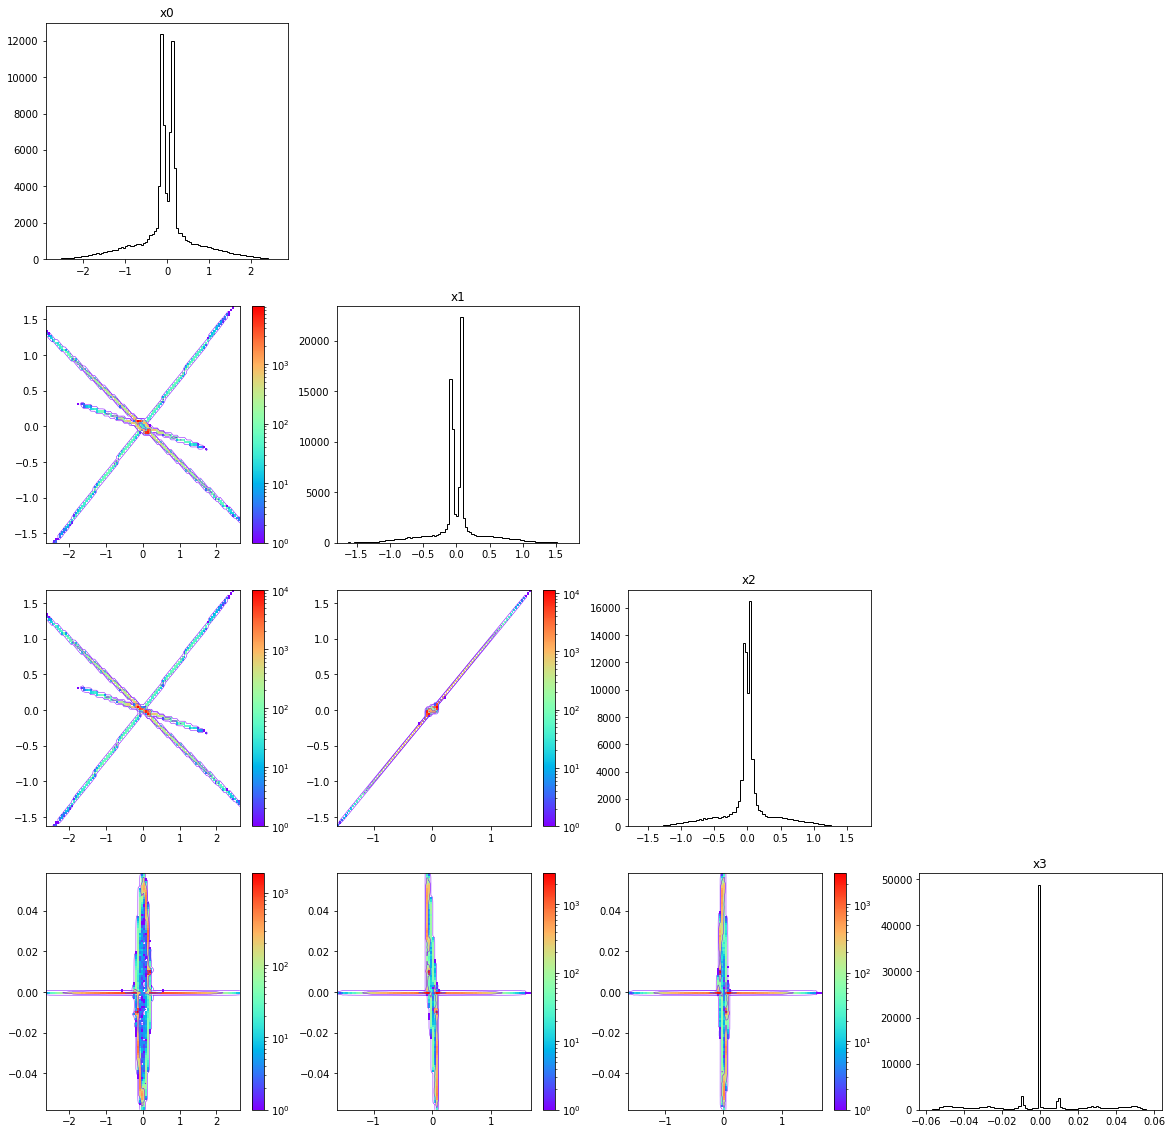

In [14]:
triangular_plot(x2.numpy())

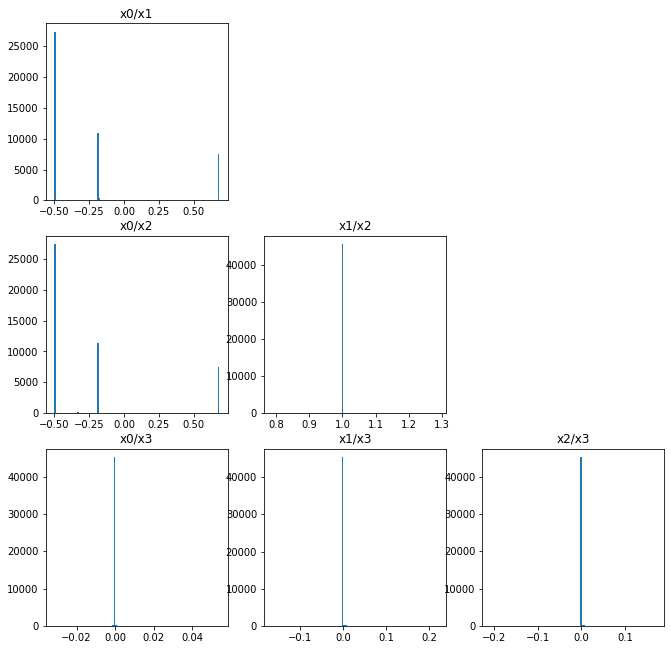

In [15]:
# compute what are the different slopes in the data
triangular_plot_slopes(x2)

In [16]:
# to be compared with the values 
print(1/(-2*(1-np.sqrt(3))))
print(1/(-2*(1+np.sqrt(3))))

0.6830127018922194
-0.18301270189221933


In [21]:
def is_on_axis(x,axis,slope,err):
    """Routine that takes an array of points, and look for those which are close to a given line with slope `slope`
    `x` : array_like. The list of points to analyse
    `axis` : tuple. What axis into which one should like. Ex : look for slope 0.5 between x1 and x2, then axis should be (0,1)
    `slope : float. The value of the slope we are looking at. 
    `err` : float. error.
    
    return : mask of True/False of size x.shape[0] where the point are close to the considered line. """
    these_slopes = x[:,axis[1]]/x[:,axis[0]]
    return np.abs(these_slopes-slope)<err

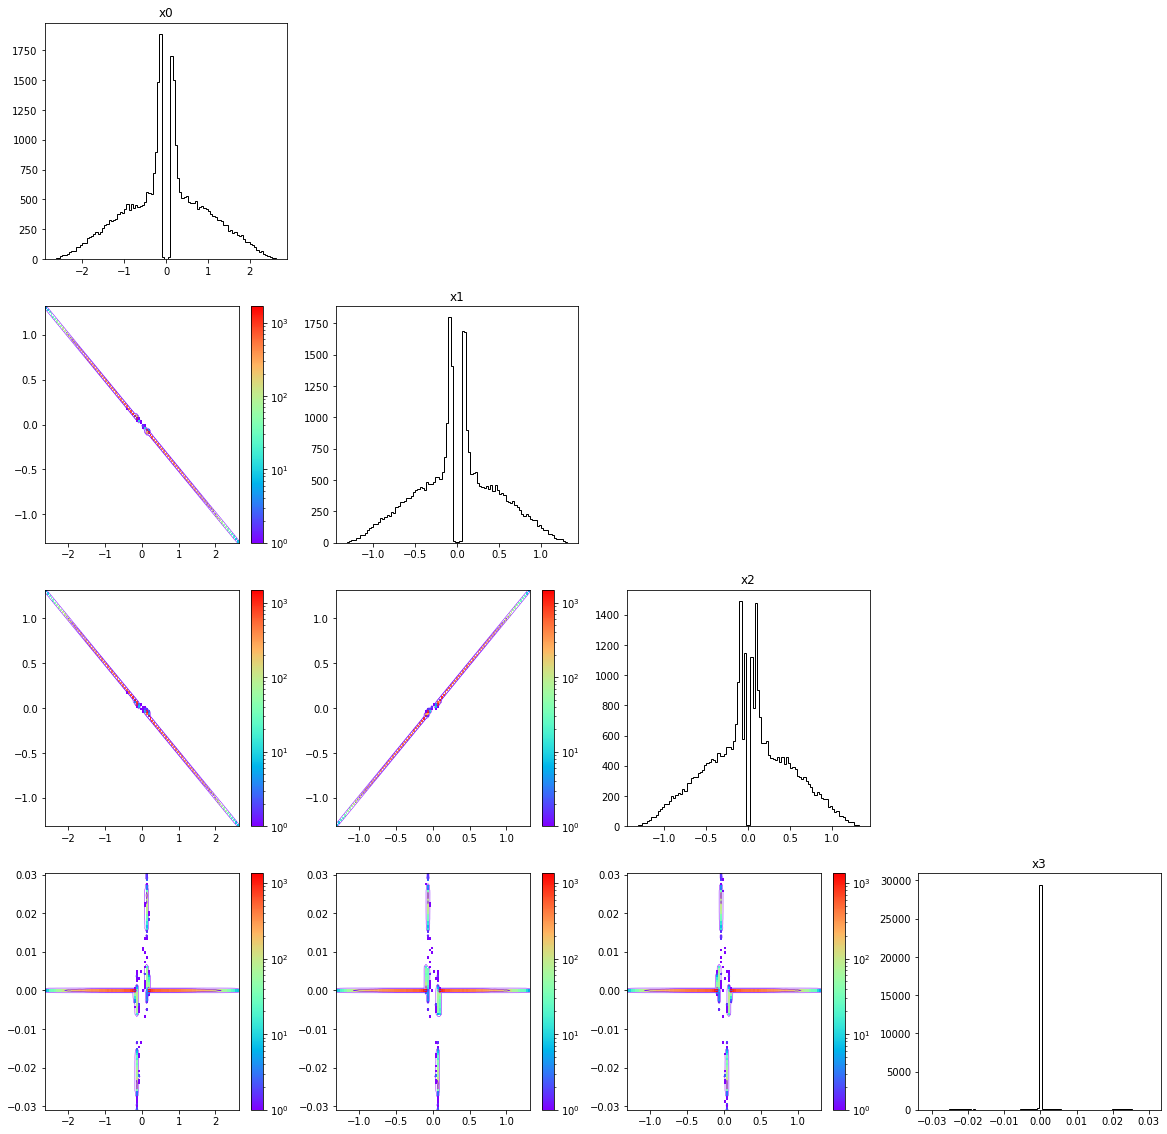

In [22]:
#Extract the point that have x1 = -0.5 x0 
mask_points=is_on_axis(x2.numpy(),(0,1),-0.5,0.05)
points=np.transpose(np.array([np.extract(mask_points,x2[:,0].numpy()),np.extract(mask_points,x2[:,1].numpy()),np.extract(mask_points,x2[:,2].numpy()),np.extract(mask_points,x2[:,3].numpy())]))
triangular_plot(points)


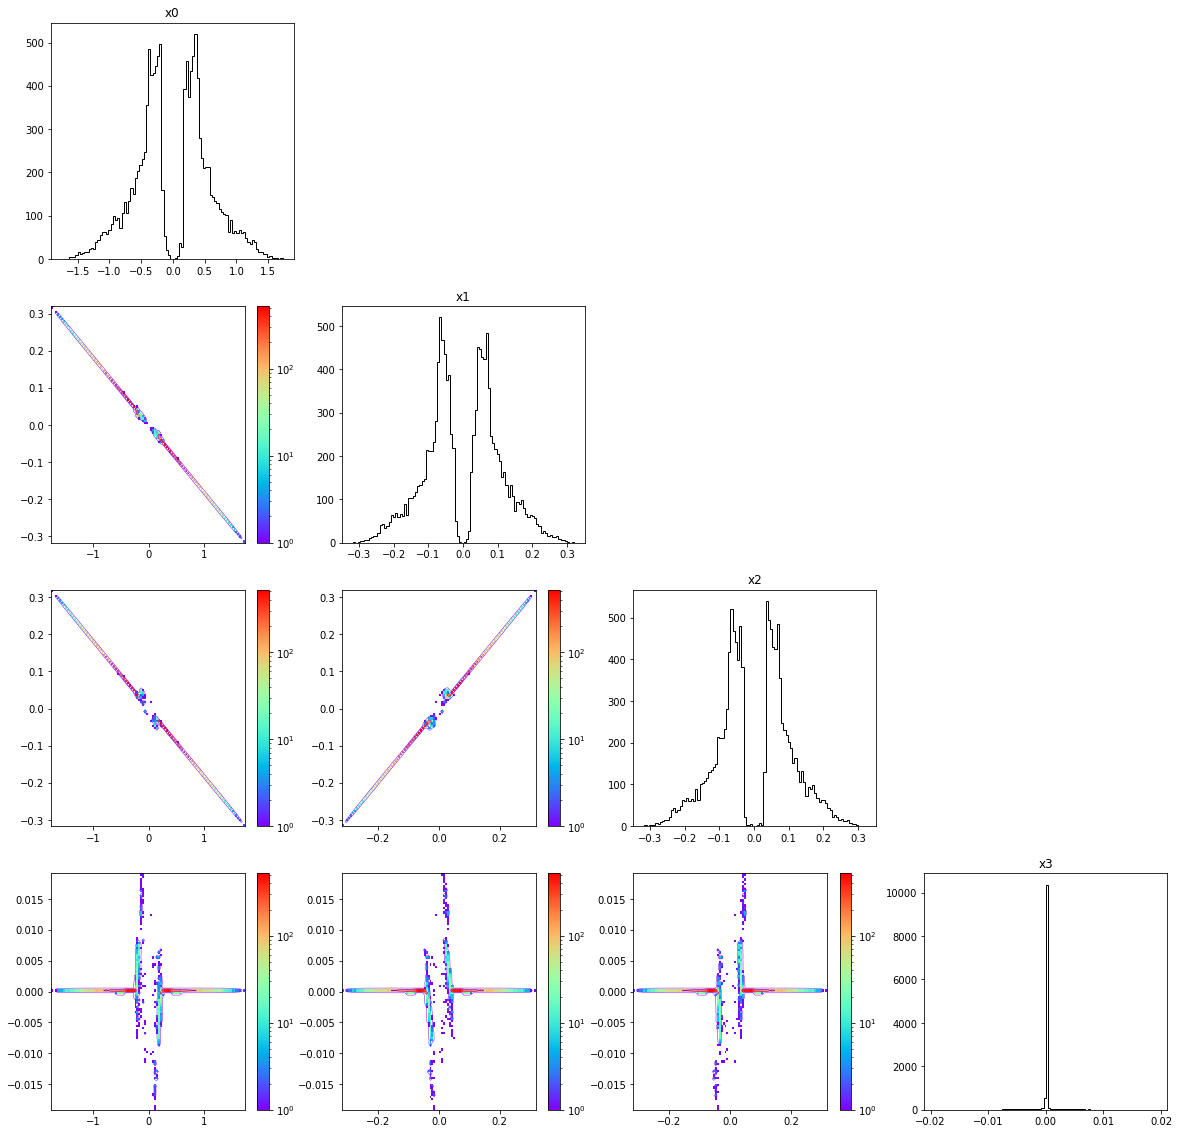

In [23]:
mask_points=is_on_axis(x2.numpy(),(0,1),-0.18,0.05)
points=np.transpose(np.array([np.extract(mask_points,x2[:,0].numpy()),np.extract(mask_points,x2[:,1].numpy()),np.extract(mask_points,x2[:,2].numpy()),np.extract(mask_points,x2[:,3].numpy())]))
triangular_plot(points)


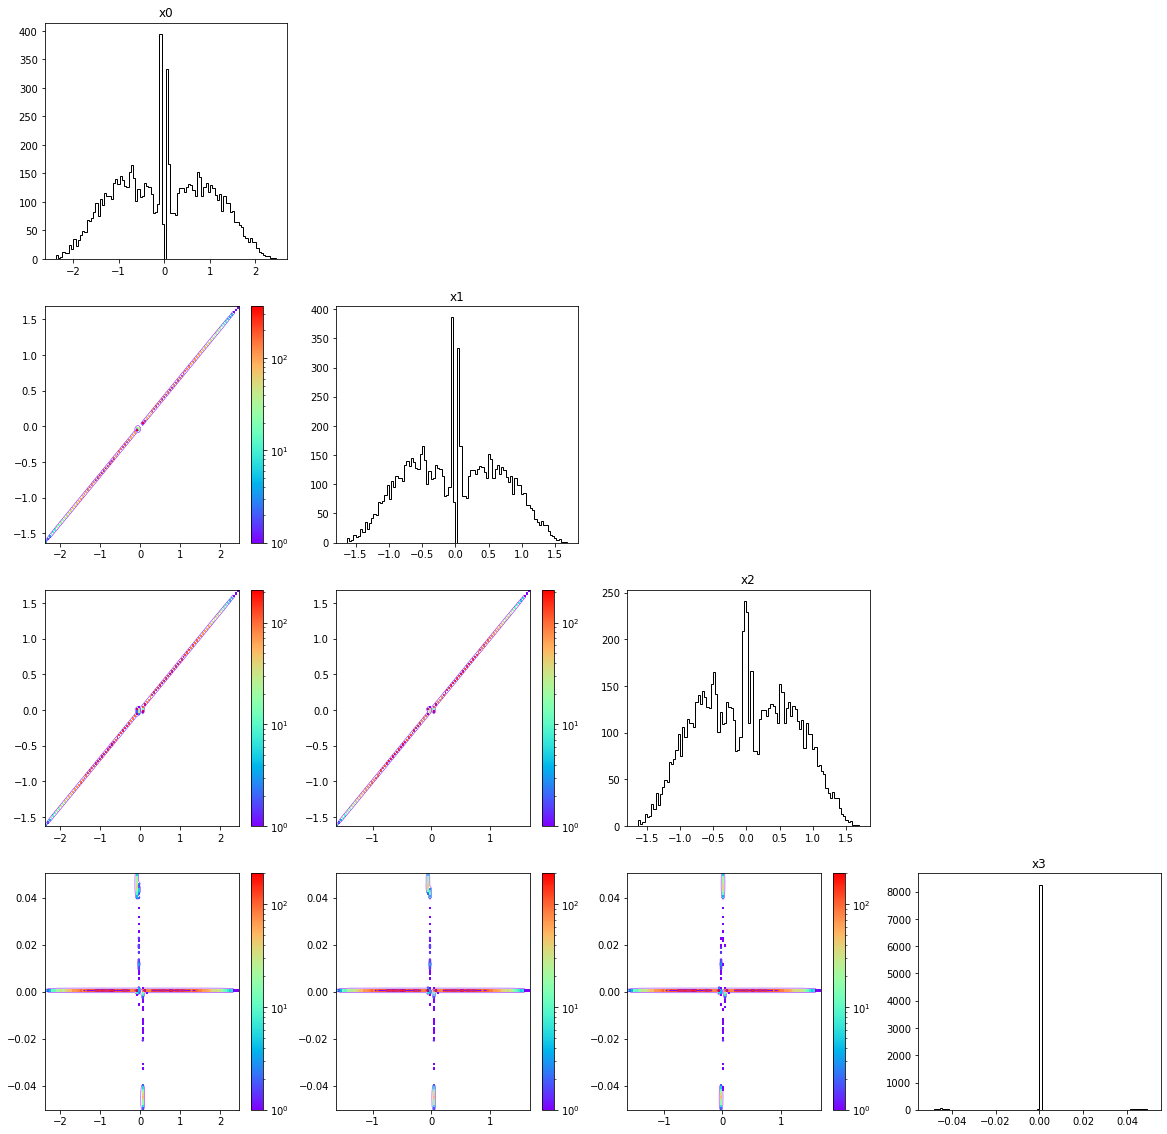

In [24]:
mask_points=is_on_axis(x2.numpy(),(0,1),0.68,0.1)
points=np.transpose(np.array([np.extract(mask_points,x2[:,0].numpy()),np.extract(mask_points,x2[:,1].numpy()),np.extract(mask_points,x2[:,2].numpy()),np.extract(mask_points,x2[:,3].numpy())]))
triangular_plot(points)


In [ ]:
#V3 potential plots and stats

In [50]:
# randomly initialize the points
n_points = 100000
x3 = tf.Variable(4*np.random.rand(n_points, 4)-2, dtype=tf.float32)

In [52]:
# Oprimizer for the gradient descent

init_alpha=10**(-2)
update_alpha = True

optimizer = tf.optimizers.Adam(learning_rate=alpha)
#optimizer = tf.optimizers.SGD(learning_rate=init_alpha,momentum=0.0)

# Learning loop 
loss_prev_step=10**8

alpha = init_alpha
update_alpha = False
update_opt = True
for step in range(2400):  
    with tf.GradientTape() as tape:
        loss = tf.reduce_sum(grad_norm_squared(V3, x3)) # minimize ||∇V||^2 for all points
    
    # Compute ||∇V||^2 with respect to x
    gradients = tape.gradient(loss, [x3])

    if update_alpha and step % 300 == 0 and step != 0:
        alpha = alpha/2
        optimizer = tf.optimizers.Adam(learning_rate=alpha)
    if update_opt and step % 200 ==0 :
        print("Reinitializing the optimizer")
        optimizer = tf.optimizers.Adam(learning_rate=init_alpha)
    if loss.numpy()<10 and update_opt:
        update_alpha = True
        update_opt = False
        print("Turning update_alpha to True and update_opt to False")
        
    # Apply gradient descent for all points
    optimizer.apply_gradients(zip(gradients, [x3]))
    
    if step % 10 == 0:
        print(f"""Step {step}: ||∇V||^2 = {loss.numpy()} with learning rate {optimizer.get_config()["learning_rate"]}""")
        
    if np.log(loss.numpy())/np.log(10)<-6: 
        print("Converged enough") 
        print(f"Step {step}: ||∇V||^2 = {loss.numpy()}")
        break

Reinitializing the optimizer
Step 0: ||∇V||^2 = 1.4940524088278385e+18 with learning rate 0.009999999776482582
Step 10: ||∇V||^2 = 5.1796797065632154e+17 with learning rate 0.009999999776482582
Step 20: ||∇V||^2 = 2.1592082215233126e+17 with learning rate 0.009999999776482582
Step 30: ||∇V||^2 = 1.1478565527538893e+17 with learning rate 0.009999999776482582
Step 40: ||∇V||^2 = 7.4033004116181e+16 with learning rate 0.009999999776482582
Step 50: ||∇V||^2 = 5.415991555968205e+16 with learning rate 0.009999999776482582
Step 60: ||∇V||^2 = 4.273445214879744e+16 with learning rate 0.009999999776482582
Step 70: ||∇V||^2 = 3.5265261355401216e+16 with learning rate 0.009999999776482582
Step 80: ||∇V||^2 = 2.99162725777408e+16 with learning rate 0.009999999776482582
Step 90: ||∇V||^2 = 2.584703587791667e+16 with learning rate 0.009999999776482582
Step 100: ||∇V||^2 = 2.262754342522061e+16 with learning rate 0.009999999776482582
Step 110: ||∇V||^2 = 2.001279954767053e+16 with learning rate 0.009

Step 1050: ||∇V||^2 = 1281.50830078125 with learning rate 0.009999999776482582
Step 1060: ||∇V||^2 = 411.59356689453125 with learning rate 0.009999999776482582
Step 1070: ||∇V||^2 = 299.7628173828125 with learning rate 0.009999999776482582
Step 1080: ||∇V||^2 = 237.839599609375 with learning rate 0.009999999776482582
Step 1090: ||∇V||^2 = 171.88327026367188 with learning rate 0.009999999776482582
Step 1100: ||∇V||^2 = 151.37669372558594 with learning rate 0.009999999776482582
Step 1110: ||∇V||^2 = 133.25991821289062 with learning rate 0.009999999776482582
Step 1120: ||∇V||^2 = 121.04010009765625 with learning rate 0.009999999776482582
Step 1130: ||∇V||^2 = 111.4173812866211 with learning rate 0.009999999776482582
Step 1140: ||∇V||^2 = 103.03849792480469 with learning rate 0.009999999776482582
Step 1150: ||∇V||^2 = 95.66978454589844 with learning rate 0.009999999776482582
Step 1160: ||∇V||^2 = 89.16012573242188 with learning rate 0.009999999776482582
Step 1170: ||∇V||^2 = 83.33290863037

Step 2050: ||∇V||^2 = 1.1386098776711151e-05 with learning rate 0.0024999999441206455
Step 2060: ||∇V||^2 = 8.582890586694703e-06 with learning rate 0.0024999999441206455
Step 2070: ||∇V||^2 = 7.032307166809915e-06 with learning rate 0.0024999999441206455
Step 2080: ||∇V||^2 = 6.881561148475157e-06 with learning rate 0.0024999999441206455
Step 2090: ||∇V||^2 = 6.483806828327943e-06 with learning rate 0.0024999999441206455
Step 2100: ||∇V||^2 = 0.00016598294314462692 with learning rate 0.0012499999720603228
Step 2110: ||∇V||^2 = 1400.2418212890625 with learning rate 0.0012499999720603228
Step 2120: ||∇V||^2 = 254.0369873046875 with learning rate 0.0012499999720603228
Step 2130: ||∇V||^2 = 23.730018615722656 with learning rate 0.0012499999720603228
Step 2140: ||∇V||^2 = 31.92056655883789 with learning rate 0.0012499999720603228
Step 2150: ||∇V||^2 = 16.392559051513672 with learning rate 0.0012499999720603228
Step 2160: ||∇V||^2 = 5.782623291015625 with learning rate 0.0012499999720603228

In [53]:
for i in range(15):
    print(f"Number of points with ||∇V||^2 > {10**(-i)} : {sum(tf.reduce_sum(get_grad(V3,x3)**2,axis=1).numpy()>10**(-i))}")


Number of points with ||∇V||^2 > 1 : 0
Number of points with ||∇V||^2 > 0.1 : 0
Number of points with ||∇V||^2 > 0.01 : 0
Number of points with ||∇V||^2 > 0.001 : 0
Number of points with ||∇V||^2 > 0.0001 : 0
Number of points with ||∇V||^2 > 1e-05 : 0
Number of points with ||∇V||^2 > 1e-06 : 0
Number of points with ||∇V||^2 > 1e-07 : 2
Number of points with ||∇V||^2 > 1e-08 : 38
Number of points with ||∇V||^2 > 1e-09 : 184
Number of points with ||∇V||^2 > 1e-10 : 1517
Number of points with ||∇V||^2 > 1e-11 : 15865
Number of points with ||∇V||^2 > 1e-12 : 59438
Number of points with ||∇V||^2 > 1e-13 : 65645
Number of points with ||∇V||^2 > 1e-14 : 69090


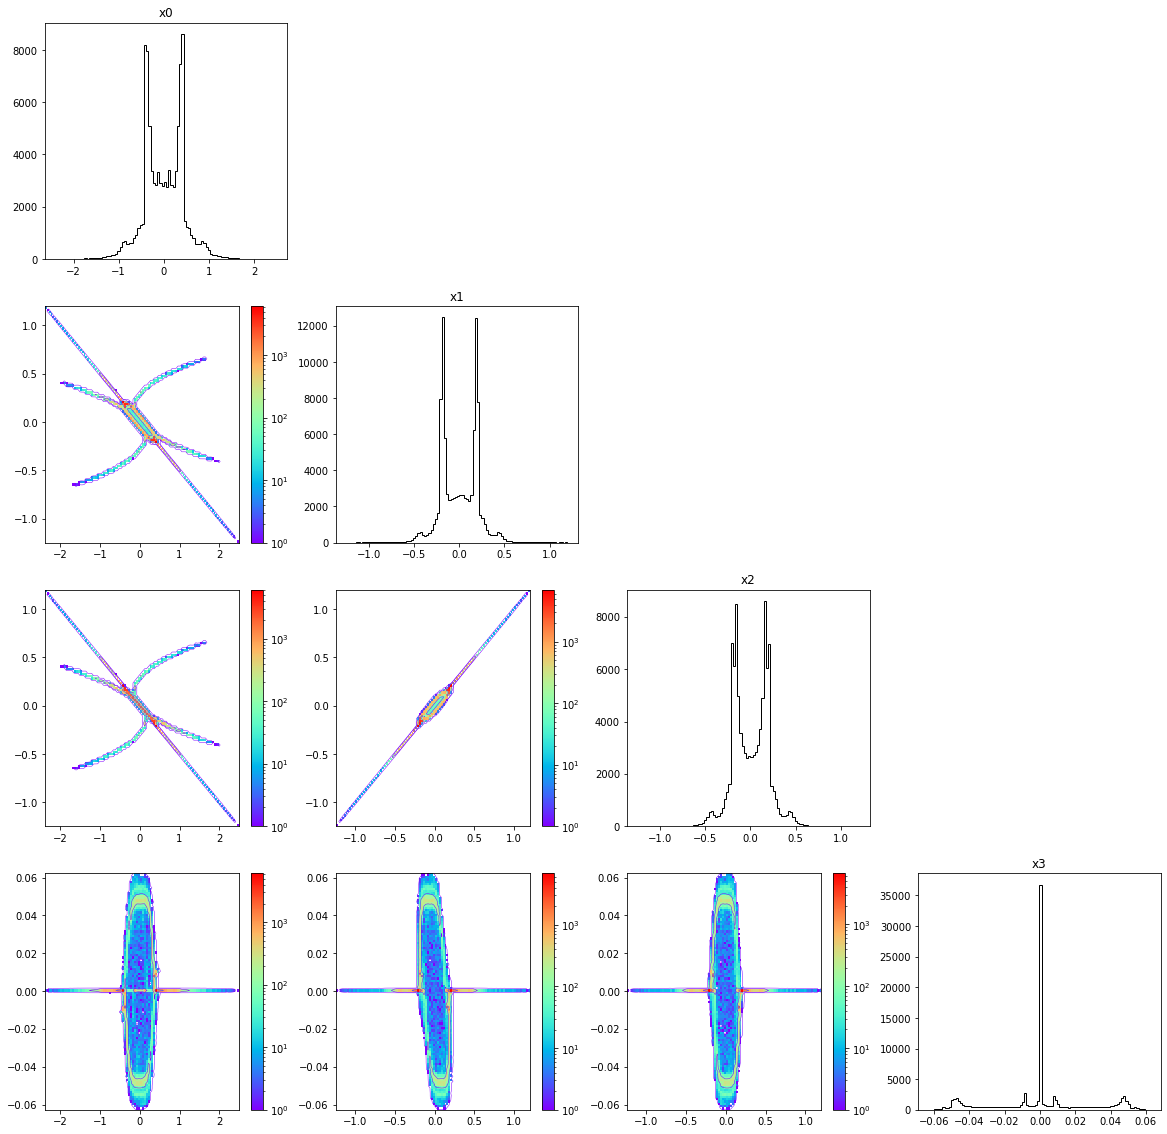

In [54]:
triangular_plot(x3.numpy())

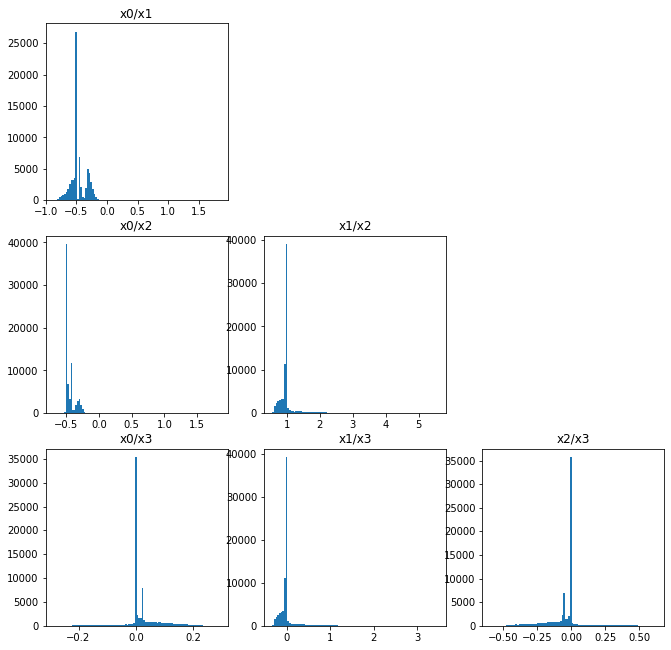

In [55]:
triangular_plot_slopes(x3)

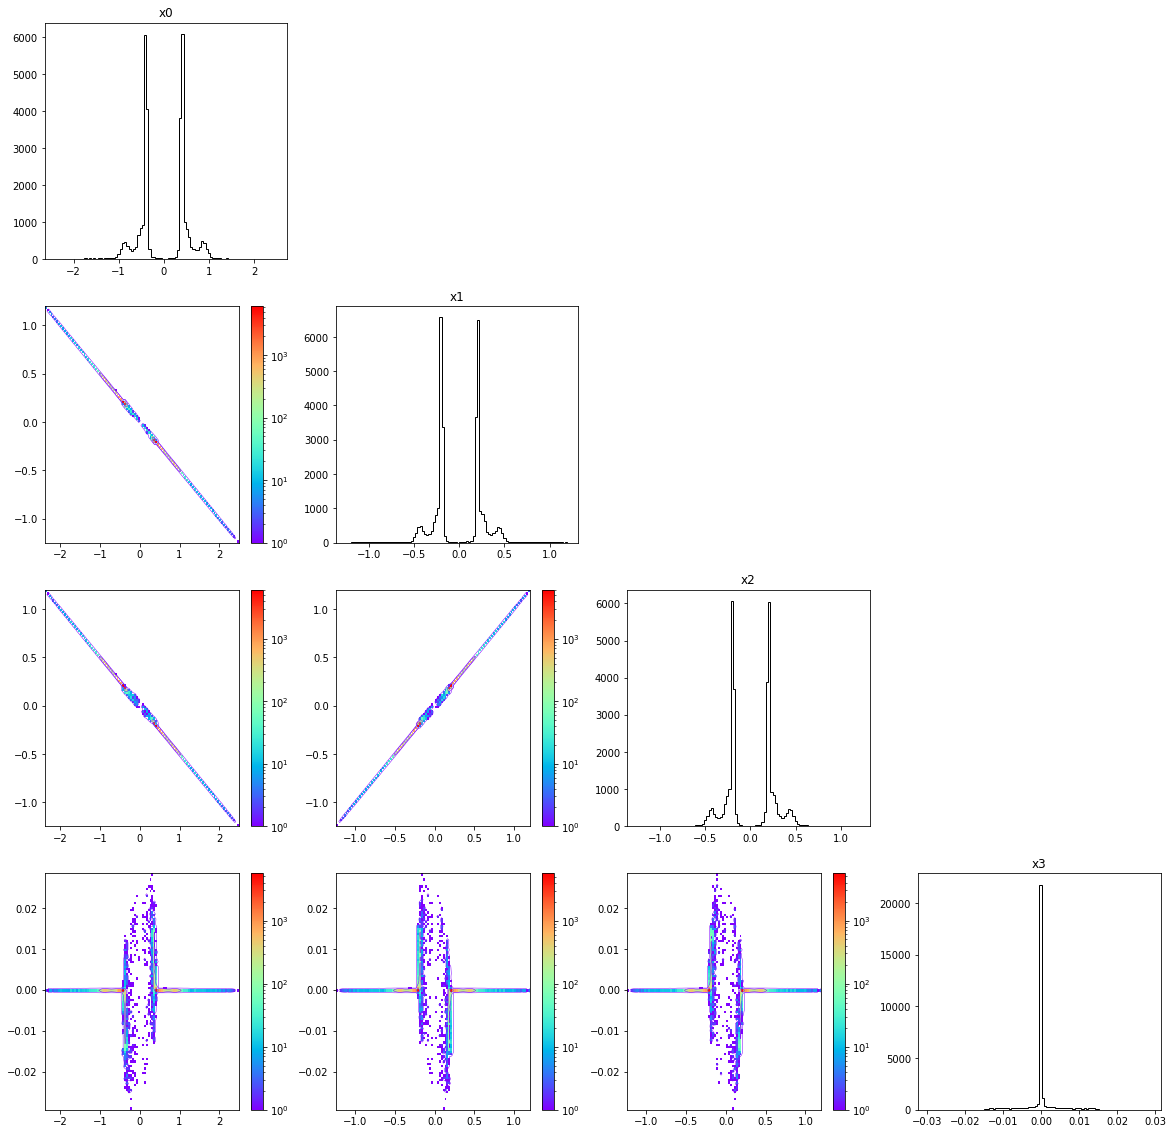

In [56]:
mask_points_m5=is_on_axis(x3.numpy(),(0,1),-0.5,0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

In [57]:
def is_on_x_squared(x,axis,coef,err):
    """Routine that takes an array of points, and look for those which are close to a given parabol.
    `x` : array_like. The list of points to analyse
    `axis` : tuple. What axis into which one should like. Ex : look for slope 0.5 between x1 and x2, then axis should be (0,1)
    `coef : float. The value of the coefficients in the polynomial : a x**2 + b x + c
    `err` : float. error.
    
    return : mask of True/False of size x.shape[0] where the point are close to the considered parabol. """
    a,b,c=coef
    return np.abs(x[:,axis[0]]-(a*x[:,axis[1]]**2+b*x[:,axis[1]]+c))<err

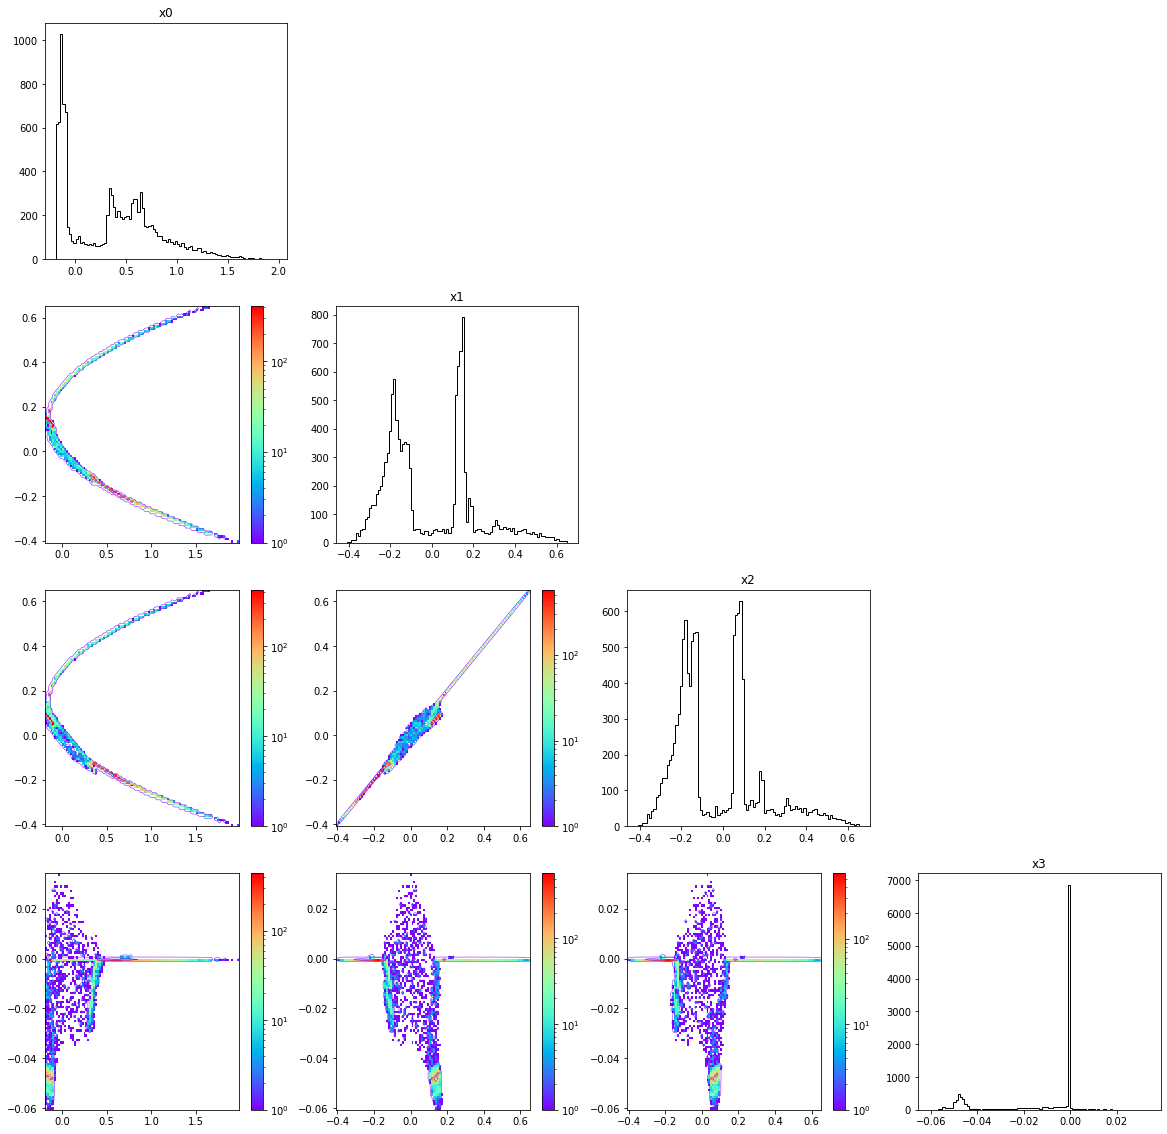

In [58]:
mask_points_m5=is_on_x_squared(x3.numpy(),(0,1),(4*np.sqrt(3),-2,0),0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)

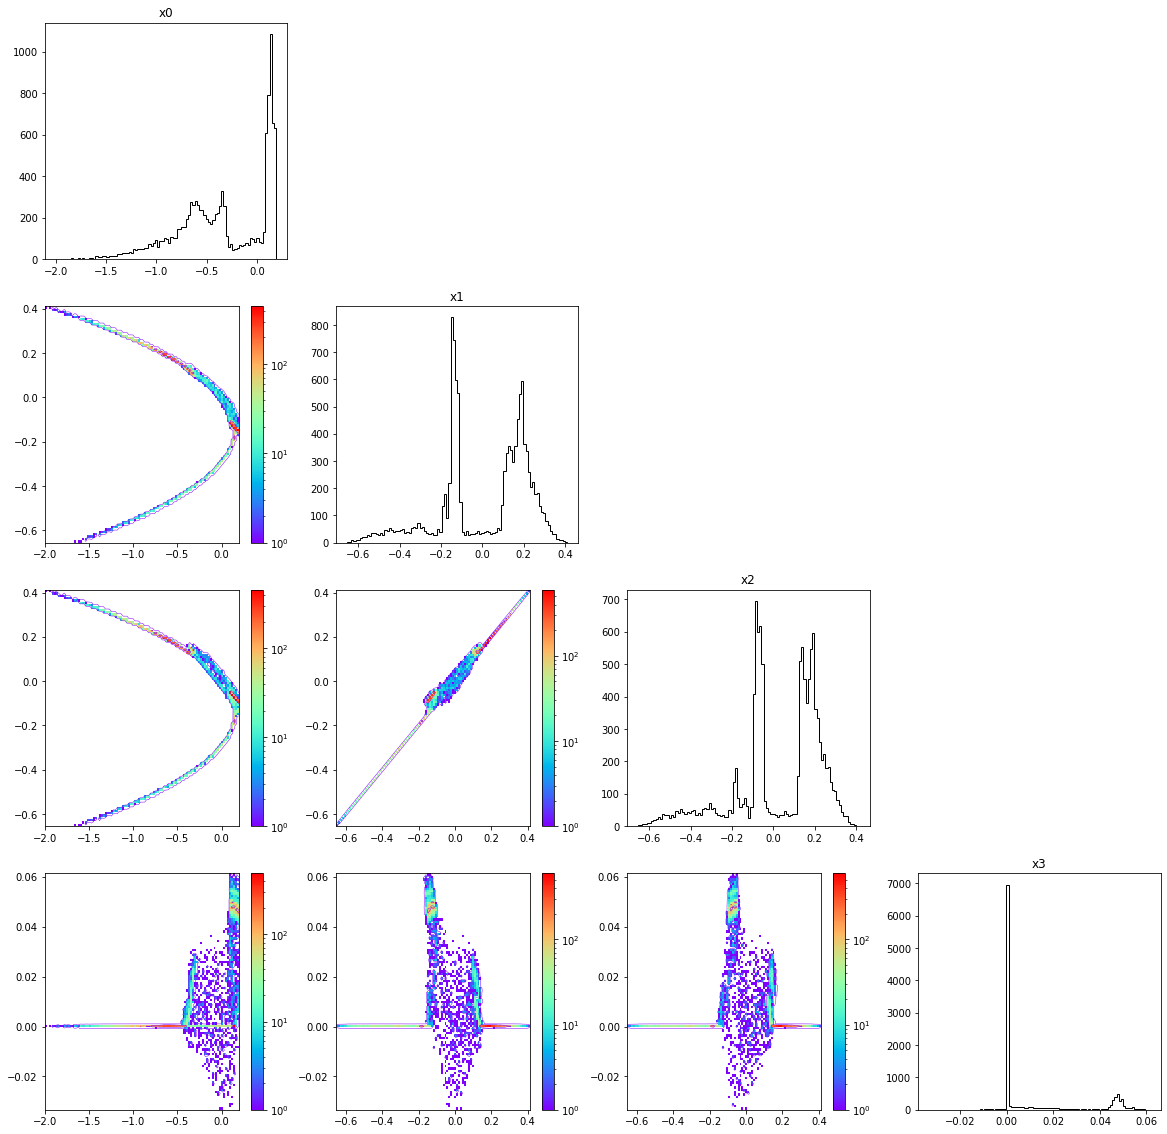

In [59]:
mask_points_m5=is_on_x_squared(x3.numpy(),(0,1),(-4*np.sqrt(3),-2,0),0.05)
points_m5=np.transpose(np.array([np.extract(mask_points_m5,x3[:,0].numpy()),np.extract(mask_points_m5,x3[:,1].numpy()),np.extract(mask_points_m5,x3[:,2].numpy()),np.extract(mask_points_m5,x3[:,3].numpy())]))
triangular_plot(points_m5)